In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models, regularizers

In [2]:
csv_file = 'sickle_dataset_tabular.csv'
df = pd.read_csv(csv_file)

In [3]:
base_dir = 'path/to/dataset'

In [4]:
data = []
labels = []

In [5]:
for index, row in df.iterrows():
    directory = str(row['UNIQUE_ID'])
    crop_name = row['CROP']
    
    dir_path = os.path.join(base_dir, directory)
    
    # Check if the directory exists
    if not os.path.exists(dir_path):
        print(f"Directory {dir_path} does not exist, skipping...")
        continue

    for file in os.listdir(dir_path):
        if file.endswith('.npz'):
            file_path = os.path.join(dir_path, file)
            
            with np.load(file_path) as npz_file:
                array_count = 0
                data_group = []
                for array_name in npz_file.files:
                    array = npz_file[array_name]
                    
                    if array.shape in [(12, 12), (11, 12,), (12, 11)]:
                        if array.shape == (11, 12):
                            padded_array = np.pad(array, ((1, 0), (0, 0)), mode='constant')
                            data_group.append(padded_array)
                        elif array.shape == (12, 11):
                            padded_array = np.pad(array, ((0, 0), (1, 0)), mode='constant')
                            data_group.append(padded_array)
                        else:
                            padded_array = array
                            data_group.append(padded_array)
                            
                        array_count += 1

                        if array_count == 19:
                            data.append(data_group)
                            labels.append(crop_name)
                            
                            data_group = []
                            array_count = 0

Directory ./dataset\1924 does not exist, skipping...
Directory ./dataset\1783 does not exist, skipping...
Directory ./dataset\2377 does not exist, skipping...
Directory ./dataset\833 does not exist, skipping...
Directory ./dataset\1296 does not exist, skipping...
Directory ./dataset\1300 does not exist, skipping...
Directory ./dataset\1178 does not exist, skipping...
Directory ./dataset\1181 does not exist, skipping...
Directory ./dataset\1855 does not exist, skipping...
Directory ./dataset\1856 does not exist, skipping...
Directory ./dataset\832 does not exist, skipping...
Directory ./dataset\823 does not exist, skipping...
Directory ./dataset\213 does not exist, skipping...
Directory ./dataset\168 does not exist, skipping...
Directory ./dataset\1923 does not exist, skipping...
Directory ./dataset\1622 does not exist, skipping...
Directory ./dataset\1525 does not exist, skipping...
Directory ./dataset\1295 does not exist, skipping...
Directory ./dataset\621 does not exist, skipping...

In [6]:
# Convert lists to arrays
data_array = np.array(data)
labels_array = np.array(labels)

In [7]:
print(len(data[0]))

19


In [8]:
unique_labels, counts = np.unique(labels_array, return_counts=True)

# Print the number of unique labels and their counts
print(f"Number of unique labels: {len(unique_labels)}")
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Number of unique labels: 14
Label: Banana, Count: 1081
Label: Banyan, Count: 254
Label: Betelwine, Count: 25
Label: Blackgram, Count: 37
Label: Coconut, Count: 602
Label: Cotton, Count: 17
Label: Eucalyptus, Count: 36
Label: Green gram, Count: 17
Label: Groundnut, Count: 46
Label: Mixed plantation, Count: 38
Label: Paddy, Count: 1261
Label: Palm tree, Count: 50
Label: Sesame, Count: 44
Label: Sugarcane, Count: 210


In [9]:
from collections import Counter

In [10]:
label_counts = Counter(labels_array)
# Initialize lists to store the filtered images and labels
filtered_images = []
filtered_labels = []

# Loop over each unique label
for label, count in label_counts.items():
    # Get indices of all images with the current label
    label_indices = np.where(labels_array == label)[0]
    
    if count > 210:
        # If the class has more than 210 images, sample 210 images
        sampled_indices = np.random.choice(label_indices, 210, replace=False)
    else:
        # If the class has 210 or fewer images, take all images
        sampled_indices = label_indices
    
    # Append the sampled images and labels to the lists
    filtered_images.append(data_array[sampled_indices])
    filtered_labels.append(labels_array[sampled_indices])

# Concatenate the lists into numpy arrays
final_images = np.concatenate(filtered_images, axis=0)
final_labels = np.concatenate(filtered_labels, axis=0)

In [11]:
print(f'Final images shape: {final_images.shape}')
print(f'Final labels shape: {final_labels.shape}')

final_label_counts = Counter(final_labels)
print('Final label distribution:')
print(final_label_counts)

Final images shape: (1360, 19, 12, 12)
Final labels shape: (1360,)
Final label distribution:
Counter({'Paddy': 210, 'Sugarcane': 210, 'Coconut': 210, 'Banana': 210, 'Banyan': 210, 'Palm tree': 50, 'Groundnut': 46, 'Sesame': 44, 'Mixed plantation': 38, 'Blackgram': 37, 'Eucalyptus': 36, 'Betelwine': 25, 'Cotton': 17, 'Green gram': 17})


In [12]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(final_labels)
categorical_labels = to_categorical(encoded_labels)

In [13]:
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [14]:
print(len(final_images))
print(len(final_labels))

1360
1360


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(final_images, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42)

# Convert the encoded labels to one-hot encoded format
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

In [17]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1088, 19, 12, 12)
y_train shape: (1088, 14)
X_test shape: (272, 19, 12, 12)
y_test shape: (272, 14)


In [2]:
# Define the model
model2 = models.Sequential()

# Input layer
model2.add(layers.InputLayer(input_shape=(19, 12, 12)))

#Convolutional layers
model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2)))

model2.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2)))

model2.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))

model2.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))

model2.add(layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))

# Flatten the output and add a fully connected layer
model2.add(layers.Flatten())
model2.add(layers.Dense(units=128, activation='relu'))

# Dropout layer
model2.add(layers.Dropout(0.25))

# Output layer 
model2.add(layers.Dense(units=14, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

C:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 19, 12, 32)          │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 6, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 6, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 5, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         983,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,602,318 (9.93 MB)

 Trainable params: 2,602,318 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history2 = model2.fit(X_train, y_train, epochs=35, batch_size=32, validation_split=0.25)

Epoch 1/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.1029 - loss: 552.9830 - val_accuracy: 0.2831 - val_loss: 2.2548
Epoch 2/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.2721 - loss: 2.2824 - val_accuracy: 0.2831 - val_loss: 2.1648
Epoch 3/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.2540 - loss: 2.2070 - val_accuracy: 0.3603 - val_loss: 1.8887
Epoch 4/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.3398 - loss: 1.9718 - val_accuracy: 0.3713 - val_loss: 1.8217
Epoch 5/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.3872 - loss: 1.7903 - val_accuracy: 0.3787 - val_loss: 1.7894
Epoch 6/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4027 - loss: 1.7776 - val_accuracy: 0.4118 - val_loss: 1.6661
Epoch 7/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.4011 - loss: 1.6733 - val_accuracy: 0.3750 - val_loss: 1.6813
Epoch 8/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3859 - loss: 1.6245 - val_accuracy: 

In [18]:
import matplotlib.pyplot as plt

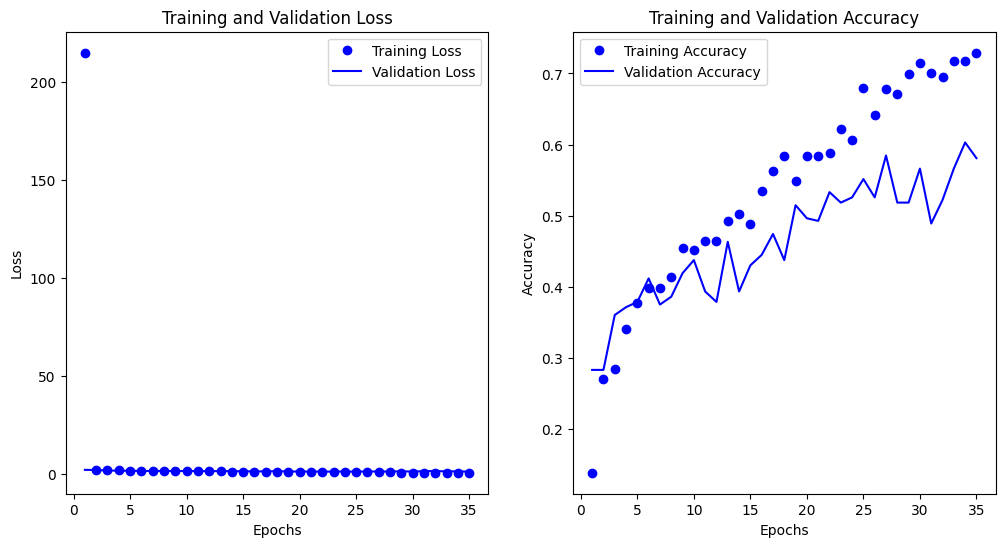

In [21]:
# Get the history data
history_dict = history2.history

# Extract the metrics
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

# Create epochs array
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
model2.save("savedmodel2.h5")

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


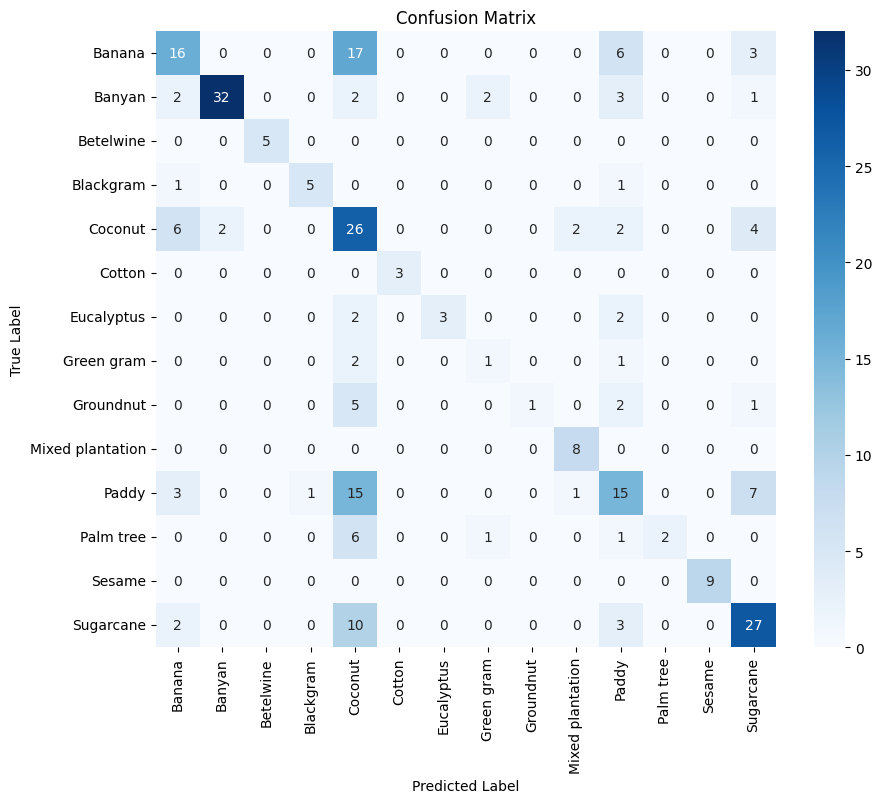

In [23]:
# Model predictions
y_pred_probs = model2.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

# Ensure y_test is in integer format (not one-hot encoded)
# If y_test is one-hot encoded, convert it back to integer labels
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=-1)

# Confusion matrix
conf_matrix = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
# Get the class names from the LabelEncoder
class_names = label_encoder.classes_

# Convert the confusion matrix to numpy array for visualization
conf_matrix = conf_matrix.numpy()

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Sum of diagonal elements
correct_predictions = np.trace(conf_matrix)

# Total number of predictions
total_predictions = np.sum(conf_matrix)

# Accuracy
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy}')

Accuracy: 0.5625


In [25]:
# Precision
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
average_precision = np.nanmean(precision)
print(f'Precision: {average_precision}')

# Recall
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
average_recall = np.nanmean(recall)
print(f'Recall: {average_recall}')

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)
average_f1 = np.nanmean(f1_score)
print(f'F1 Score: {average_f1}')

Precision: 0.759683704348547
Recall: 0.6047052154195011
F1 Score: 0.6221840996060299


In [20]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("savedmodel2.h5")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


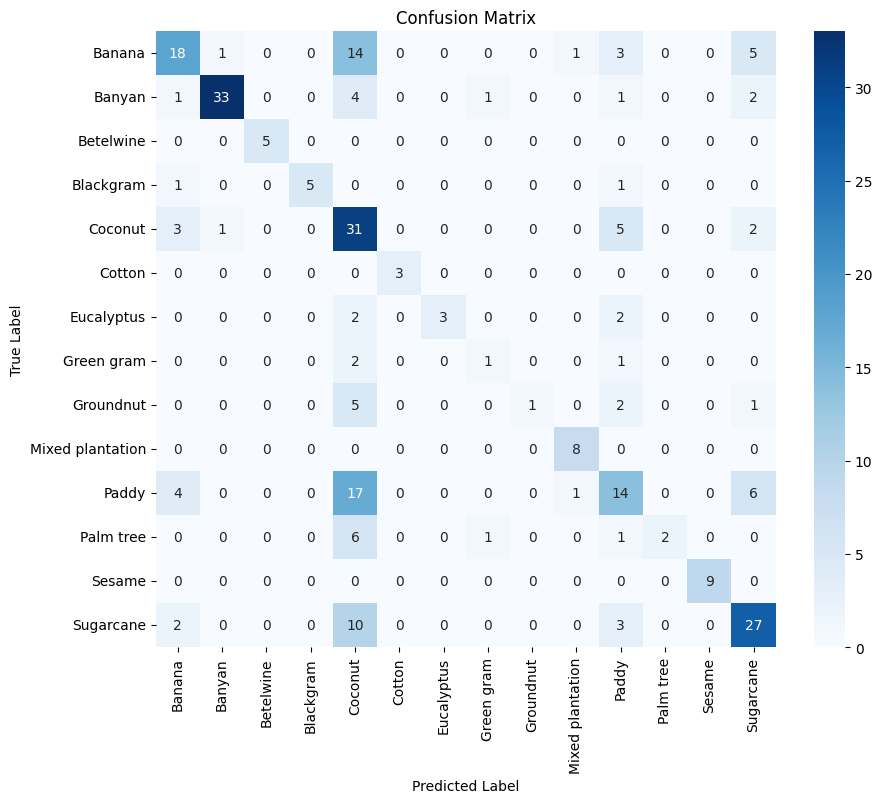

In [21]:
# Model predictions
lm_y_pred_probs = loaded_model.predict(X_test)
lm_y_pred = np.argmax(lm_y_pred_probs, axis=-1)

# Ensure y_test is in integer format (not one-hot encoded)
# If y_test is one-hot encoded, convert it back to integer labels
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=-1)

# Confusion matrix
lm_conf_matrix = tf.math.confusion_matrix(labels=y_test, predictions=lm_y_pred)
# Get the class names from the LabelEncoder
class_names = label_encoder.classes_

# Convert the confusion matrix to numpy array for visualization
lm_conf_matrix = lm_conf_matrix.numpy()

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(lm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Sum of diagonal elements
lm_correct_predictions = np.trace(lm_conf_matrix)

# Total number of predictions
lm_total_predictions = np.sum(lm_conf_matrix)

# Accuracy
lm_accuracy = lm_correct_predictions / lm_total_predictions
print(f'Accuracy: {lm_accuracy}')

# Precision
lm_precision = np.diag(lm_conf_matrix) / np.sum(lm_conf_matrix, axis=0)
lm_average_precision = np.nanmean(lm_precision)
print(f'Precision: {lm_average_precision}')

# Recall
lm_recall = np.diag(lm_conf_matrix) / np.sum(lm_conf_matrix, axis=1)
lm_average_recall = np.nanmean(lm_recall)
print(f'Recall: {lm_average_recall}')

# F1 Score
lm_f1_score = 2 * (lm_precision * lm_recall) / (lm_precision + lm_recall)
lm_average_f1 = np.nanmean(lm_f1_score)
print(f'F1 Score: {lm_average_f1}')

Accuracy: 0.5882352941176471
Precision: 0.7921206337863458
Recall: 0.616609977324263
F1 Score: 0.6414462726034322
